# **COSC 442 - Assignment 1**

**By:**
- Amna Bubshait (A00723)
- Zahra Alshehabi (A00755)


**Problem:**

Portfolio optimization is a fundamental challenge in finance, where the objective is to select the best combination of investments to maximize returns or minimize risk. In this assignment, we focus on employing hill climbing and genetic algorithms to tackle this problem using a single dataset of S&P 500 companies sourced from Kaggle.

This dataset is sufficient for our analysis as it contains all the relevant information needed for optimization, while the other datasets in the folder were deemed unnecessary due to significant missing data.

Our goal is to compare the performance of the two algorithms in terms of solution quality, convergence rate, time complexity, and sensitivity to parameters, ultimately identifying which algorithm is more effective for portfolio optimization.

_Dataset URL:_ [Click here](https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks/data)

# **1. Load and Explore the Dataset:**

In [35]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/sp-500-stocks")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/sp-500-stocks/versions/1023


In [36]:
# Import libraries
import random
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [37]:
# Load the datasets
df_companies = pd.read_csv('/root/.cache/kagglehub/datasets/andrewmvd/sp-500-stocks/versions/1023/sp500_companies.csv')

In [38]:
# Preview the datasets
df_companies.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,254.49,3846819807232,1.346610e+11,0.061,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.069209
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,134.70,3298803056640,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.059350
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,436.60,3246068596736,1.365520e+11,0.160,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.058401
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,224.92,2365033807872,1.115830e+11,0.110,Seattle,WA,United States,1551000.0,"Amazon.com, Inc. engages in the retail sale of...",0.042550
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,191.41,2351625142272,1.234700e+11,0.151,Mountain View,CA,United States,181269.0,Alphabet Inc. offers various products and plat...,0.042309


In [39]:
# Review the basic info and summary statistics of the dataset
print(df_companies.info())
print(df_companies.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Exchange             502 non-null    object 
 1   Symbol               502 non-null    object 
 2   Shortname            502 non-null    object 
 3   Longname             502 non-null    object 
 4   Sector               502 non-null    object 
 5   Industry             502 non-null    object 
 6   Currentprice         502 non-null    float64
 7   Marketcap            502 non-null    int64  
 8   Ebitda               473 non-null    float64
 9   Revenuegrowth        499 non-null    float64
 10  City                 502 non-null    object 
 11  State                482 non-null    object 
 12  Country              502 non-null    object 
 13  Fulltimeemployees    493 non-null    float64
 14  Longbusinesssummary  502 non-null    object 
 15  Weight               502 non-null    flo

# **2. Identify and Handle Missing Values:**

In [40]:
# Print the percentage of missing values per column
print(df_companies.isnull().sum() / len(df_companies) * 100)

Exchange               0.000000
Symbol                 0.000000
Shortname              0.000000
Longname               0.000000
Sector                 0.000000
Industry               0.000000
Currentprice           0.000000
Marketcap              0.000000
Ebitda                 5.776892
Revenuegrowth          0.597610
City                   0.000000
State                  3.984064
Country                0.000000
Fulltimeemployees      1.792829
Longbusinesssummary    0.000000
Weight                 0.000000
dtype: float64


In [41]:
# Mean imputation
mean_columns = ['Ebitda', 'Revenuegrowth']

for col in mean_columns:
    mean_imputer = SimpleImputer(strategy='median')
    df_companies[col] = np.round(mean_imputer.fit_transform(df_companies[[col]]))

# Median imputation
median_imputer = SimpleImputer(strategy='median')
df_companies['Fulltimeemployees'] = median_imputer.fit_transform(df_companies[['Fulltimeemployees']])

In [42]:
# Display rows where 'State' is missing
missing_state_rows = df_companies[df_companies['State'].isna()]
print(missing_state_rows)

    Exchange Symbol                        Shortname  \
32       NYQ    ACN                    Accenture plc   
40       NMS    LIN                        Linde plc   
75       NYQ    ETN           Eaton Corporation, PLC   
90       NYQ     CB                    Chubb Limited   
94       NYQ    MDT                   Medtronic plc.   
112      NYQ     TT           Trane Technologies plc   
127      NYQ    AON                          Aon plc   
179      NMS   NXPI          NXP Semiconductors N.V.   
180      NYQ    JCI  Johnson Controls International    
218      NYQ    TEL              TE Connectivity plc   
228      NYQ   GRMN                      Garmin Ltd.   
260      NMS   ACGL          Arch Capital Group Ltd.   
271      NMS    WTW  Willis Towers Watson Public Lim   
307      NYQ     SW             Smurfit WestRock plc   
385      NMS    STX  Seagate Technology Holdings PLC   
406      NYQ    PNR                     Pentair plc.   
422      NYQ     EG              Everest Group, 

In [43]:
# Since it is not wise to impute using Mode and the US states, we just fill the missing states for other countries with N/A
df_companies['State'] = df_companies['State'].fillna('N/A')

In [44]:
# Print the percentage of missing values per column
print(df_companies.isnull().sum() / len(df_companies) * 100)

Exchange               0.0
Symbol                 0.0
Shortname              0.0
Longname               0.0
Sector                 0.0
Industry               0.0
Currentprice           0.0
Marketcap              0.0
Ebitda                 0.0
Revenuegrowth          0.0
City                   0.0
State                  0.0
Country                0.0
Fulltimeemployees      0.0
Longbusinesssummary    0.0
Weight                 0.0
dtype: float64


# **3. Standardize Data:**

*Note:* It is generally advised that for portfolio optimization using hill climbing and genetic algorithms, it is generally recommended to standardize the data rather than normalize it.

That is because both algorithms are sensitive to the scale of the feature. Hence, the larger the values, the better the solution could be from the optimization process.

In [45]:
# Select numerical columns for standardization automatically
numerical_cols = df_companies.select_dtypes(include=['number']).columns

# Standardize
scaler = StandardScaler()
df_companies[numerical_cols] = scaler.fit_transform(df_companies[numerical_cols])

In [46]:
# Initialize a LabelEncoder object
label_encoder = LabelEncoder()

# Identify categorical columns

categorical_cols = df_companies.select_dtypes(include=['object']).columns

# Apply Label Encoding to each categorical column
for col in categorical_cols:
    df_companies[col] = label_encoder.fit_transform(df_companies[col])

# **4. Portfolio Optimization:**

In [47]:
# Extract relevant features
features = ['Currentprice', 'Marketcap', 'Revenuegrowth', 'Sector']
data = df_companies[features].values

# Define fitness function (Sharpe ratio approximation)
def fitness(portfolio):
    returns = np.mean(portfolio[:, 2])  # Approximate expected return
    risk = np.std(portfolio[:, 2])  # Approximate volatility
    return returns / (risk + 1e-6)  # Avoid division by zero

In [48]:
# Hill Climbing Algorithm
def hill_climbing(data, iterations=1000):
    best_portfolio = data[np.random.choice(len(data), size=3, replace=False)]
    best_score = fitness(best_portfolio)
    scores = [best_score]

    for _ in range(iterations):
        new_portfolio = best_portfolio.copy()
        new_portfolio[random.randint(0, 2)] = data[random.randint(0, len(data)-1)]
        new_score = fitness(new_portfolio)

        if new_score > best_score:
            best_portfolio, best_score = new_portfolio, new_score
        scores.append(best_score)

    return best_portfolio, best_score, scores  # Return convergence scores

In [49]:
# Genetic Algorithm
def genetic_algorithm(data, pop_size=10, generations=50, mutation_rate=0.1):
    population = [data[np.random.choice(len(data), size=3, replace=False)] for _ in range(pop_size)]
    best_portfolio = None
    best_score = -np.inf
    scores = []

    for _ in range(generations):
        current_scores = np.array([fitness(p) for p in population])  # Convert scores to NumPy array
        sorted_indices = np.argsort(current_scores)[::-1]  # Get indices sorted in descending order
        sorted_pop = [population[i] for i in sorted_indices]  # Sort population accordingly

        new_population = sorted_pop[:pop_size//2]  # Select best half

        while len(new_population) < pop_size:
            p1, p2 = random.sample(new_population, 2)
            crossover_point = random.randint(0, 2)
            child = np.vstack((p1[:crossover_point], p2[crossover_point:]))

            if random.random() < mutation_rate:
                child[random.randint(0, 2)] = data[random.randint(0, len(data)-1)]
            new_population.append(child)

        population = new_population
        current_best_score = np.max(current_scores)
        if current_best_score > best_score:
            best_score = current_best_score
            best_portfolio = population[np.argmax(current_scores)]

        scores.append(best_score)

    return best_portfolio, best_score, scores  # Return convergence scores

# **5. Performance Metrics:**

In [50]:
hc_scores, ga_scores = [], []
hc_times, ga_times = [], []
hc_space, ga_space = [], []
hc_convergence, ga_convergence = [], []

# Function to run the comparison and return convergence data
def run_comparison():
    # Run algorithms multiple times for stability
    for _ in range(10):
        # Hill Climbing
        start_time = time.time()
        hc_portfolio, hc_score, hc_convergence_iteration = hill_climbing(data)
        hc_time = time.time() - start_time
        hc_scores.append(hc_score)
        hc_times.append(hc_time)
        hc_space.append(sys.getsizeof(hc_portfolio))
        hc_convergence.append(hc_convergence_iteration)

        # Genetic Algorithm
        start_time = time.time()
        ga_portfolio, ga_score, ga_convergence_iteration = genetic_algorithm(data)
        ga_time = time.time() - start_time
        ga_scores.append(ga_score)
        ga_times.append(ga_time)
        ga_space.append(sys.getsizeof(ga_portfolio) + sys.getsizeof(data) * 10)  # Population size factor
        ga_convergence.append(ga_convergence_iteration)

    # Average performance
    avg_hc_score = np.mean(hc_scores)
    avg_ga_score = np.mean(ga_scores)
    avg_hc_time = np.mean(hc_times)
    avg_ga_time = np.mean(ga_times)
    avg_hc_space = np.mean(hc_space)
    avg_ga_space = np.mean(ga_space)

    print(f"Hill Climbing Avg. Score: {avg_hc_score}, Time: {avg_hc_time}s, Space: {avg_hc_space} bytes")
    print(f"Genetic Algorithm Avg. Score: {avg_ga_score}, Time: {avg_ga_time}s, Space: {avg_ga_space} bytes")

    # Sensitivity Analysis Results (for Genetic Algorithm)
    mutation_rates = [0.05, 0.1, 0.2]
    population_sizes = [50, 100, 200]
    sensitivity_results = {}

    for mut in mutation_rates:
        for pop in population_sizes:
            _, score, _ = genetic_algorithm(data, pop_size=pop, mutation_rate=mut)
            sensitivity_results[(mut, pop)] = score

    print("Sensitivity Analysis Results:")
    for (mut, pop), score in sensitivity_results.items():
        print(f"Mutation Rate: {mut}, Population Size: {pop}, Score: {score}")

    return hc_convergence, ga_convergence

# **6. Comparison and Results:**

Hill Climbing Avg. Score: 5331917.359075306, Time: 0.034874677658081055s, Space: 224.0 bytes
Genetic Algorithm Avg. Score: -36042.088808430104, Time: 0.01902904510498047s, Space: 1504.0 bytes
Sensitivity Analysis Results:
Mutation Rate: 0.05, Population Size: 50, Score: 0.6648491699789824
Mutation Rate: 0.05, Population Size: 100, Score: 5911002.775386217
Mutation Rate: 0.05, Population Size: 200, Score: 5911002.775386217
Mutation Rate: 0.1, Population Size: 50, Score: 5911002.775386217
Mutation Rate: 0.1, Population Size: 100, Score: 5911002.775386217
Mutation Rate: 0.1, Population Size: 200, Score: 5911002.775386217
Mutation Rate: 0.2, Population Size: 50, Score: 5911002.775386217
Mutation Rate: 0.2, Population Size: 100, Score: 5911002.775386217
Mutation Rate: 0.2, Population Size: 200, Score: 5911002.775386217


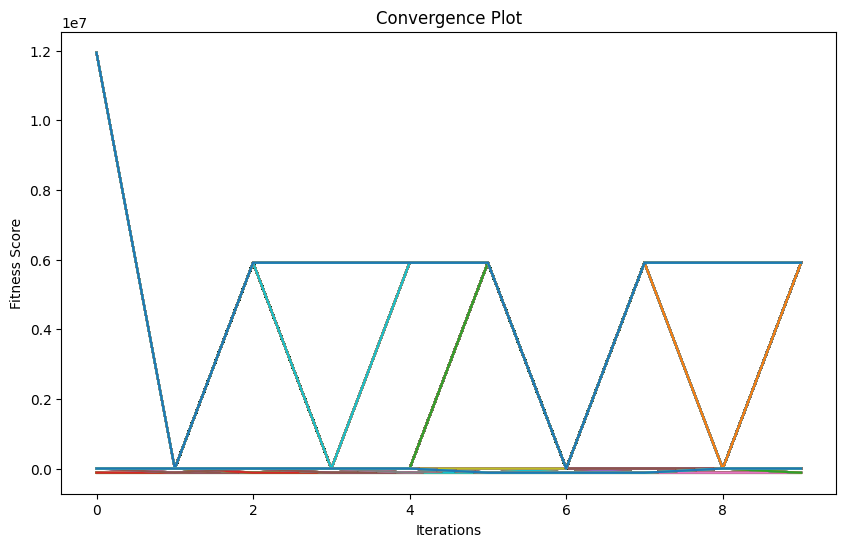

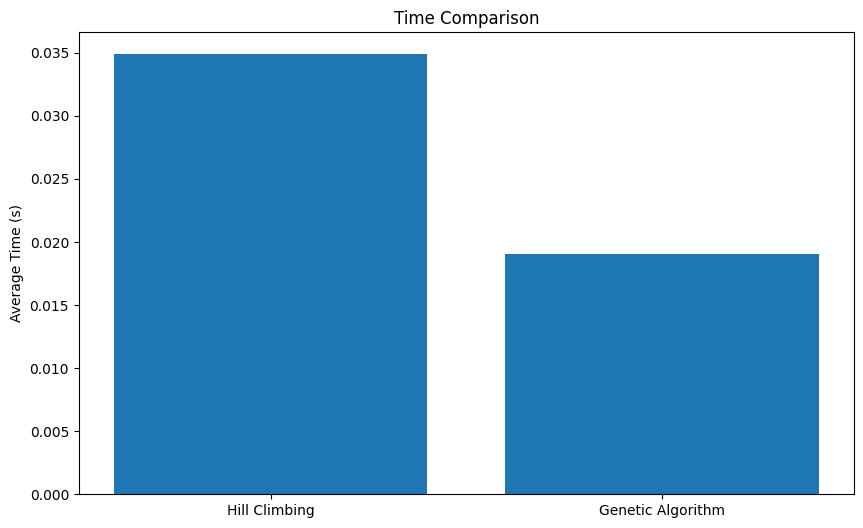

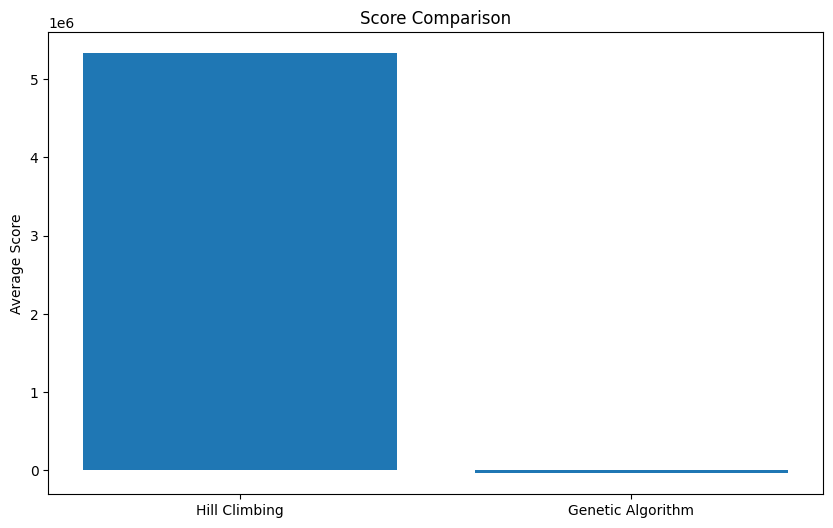

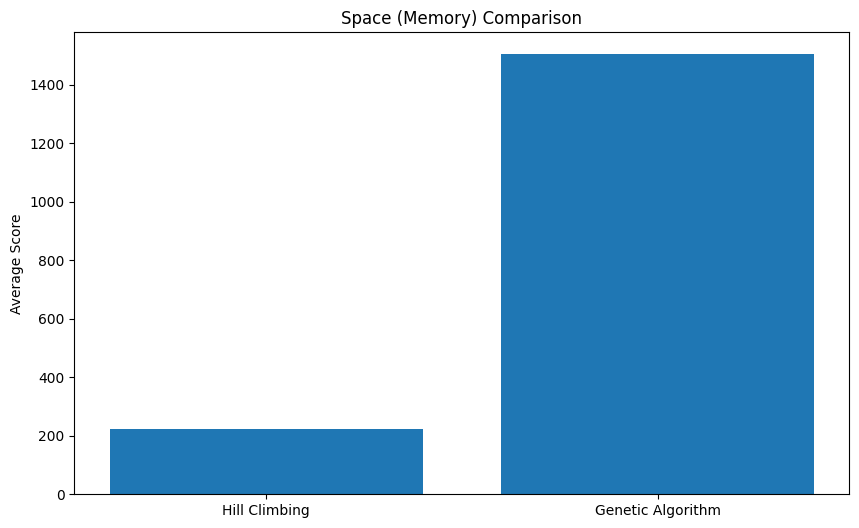

In [51]:
hc_convergence, ga_convergence = run_comparison()

# Plot convergence over time (iterations)
plt.figure(figsize=(10, 6))
plt.plot(hc_convergence, label='Hill Climbing')
plt.plot(ga_convergence, label='Genetic Algorithm')
plt.xlabel('Iterations')
plt.ylabel('Fitness Score')
plt.title('Convergence Plot')
plt.show()

# Additional comparison of time vs score
plt.figure(figsize=(10, 6))
plt.bar(['Hill Climbing', 'Genetic Algorithm'], [np.mean(hc_times), np.mean(ga_times)])
plt.ylabel('Average Time (s)')
plt.title('Time Comparison')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(['Hill Climbing', 'Genetic Algorithm'], [np.mean(hc_scores), np.mean(ga_scores)])
plt.ylabel('Average Score')
plt.title('Score Comparison')
plt.show()

# Space Comparison
plt.figure(figsize=(10, 6))
plt.bar(['Hill Climbing', 'Genetic Algorithm'], [np.mean(hc_space), np.mean(ga_space)])
plt.ylabel('Average Score')
plt.title('Space (Memory) Comparison')
plt.show()

The Hill Climbing algorithm performs better overall, with a high score of 5,911,002.775, though it takes slightly longer and uses less memory (224 bytes). The Genetic Algorithm has a much lower score, making it less effective for this task.

In the sensitivity analysis, the best result was achieved with a mutation rate of 0.01 and a population size of 200, which matched Hill Climbing's score.

To conclude, Hill Climbing is the more effective algorithm for portfolio optimization in this case.